In [52]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
#import pandas as pd
from tqdm import tqdm
import xarray as xr

from rate_model import RateModelWC

Min: 0.0000, Max: 0.1478, Mean: 0.0107, Std: 0.0345


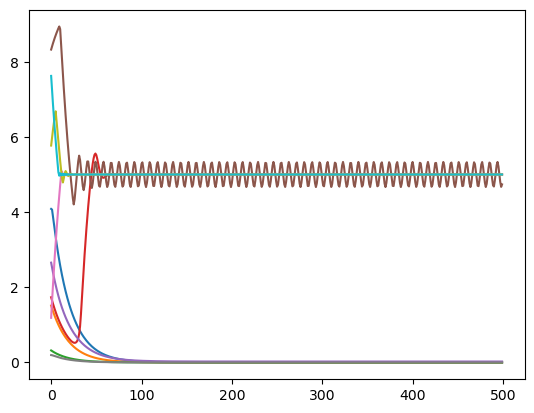

In [49]:
#SEED = 112
#np.random.seed(SEED)

# Model params
N = 2
w_sigma = 25
h0_sigma = 50
model_par = dict(tau=1, rmax=10, gain_slope=0.5, gain_center=0)
sim_par = {'dt': 0.05, 'nsteps': 500}

# Dataset params
n_model_gens = 10
n_point_gens = 1

# Create xarray dataset
X = xr.Dataset(
    {
        'W': (['model', 'pop_in', 'pop'], np.zeros((n_model_gens, N, N))),
        'H': (['model', 'point', 'pop'], np.zeros((n_model_gens, n_point_gens, N))),
        'R': (['model', 'point', 'pop', 'time'],
              np.zeros((n_model_gens, n_point_gens, N, sim_par['nsteps']))),
        'DR': (['model', 'point', 'pop'], np.zeros((n_model_gens, n_point_gens, N))),
    },
    coords={
        'model': np.arange(n_model_gens),
        'point': np.arange(n_point_gens),
        'pop': np.arange(N),
        'pop_in': np.arange(N),
        'time': np.arange(sim_par['nsteps'])
    }
)

for n in range(n_model_gens):
    #print(f'Model: {n + 1}/{n_model_gens}', flush=True)

    # Generate weights
    #while True:
    #    W = w_sigma * (2 * np.random.rand(N, N) - 1)
    #    if np.imag(np.linalg.eigvals(W)[0]) > 0:
    #        X['W'].loc[{'model': n}] = W
    #        break
    W = w_sigma * (2 * np.random.rand(N, N) - 1)
    X['W'].loc[{'model': n}] = W

    # Initialize model
    model = RateModelWC(W, **model_par)
    model.sim_res_type = 'full'

    for m in range(n_point_gens):
        cc = {'model': n, 'point': m}

        # Generate external input
        #h0 = h0_sigma * (2 * np.random.rand(N, 1) - 1)
        h0 = -W @ np.array([[5]] * 2)
        X['H'].loc[cc] = h0.ravel()

        # Run the model
        r0 = 10 * np.random.rand(N, 1)
        R = model.run(h0, r0=r0, **sim_par)
        X['R'].loc[cc] = R.values
        DR = R.isel(time=-1, drop=True) - R.isel(time=-2, drop=True)
        X['DR'].loc[cc] = DR.values.ravel()

# Compute statistics for unrolled absolute values of X['DR']
dr_abs = np.abs(X['DR'].values.ravel())
#dr_abs = np.abs((X['DR'] / X['R']).values.ravel())
print(f"Min: {dr_abs.min():.04f}, Max: {dr_abs.max():.04f}, "
      f"Mean: {dr_abs.mean():.04f}, Std: {dr_abs.std():.04f}")

plt.figure()
for n in range(n_model_gens):
    l = np.linalg.eigvals(X['W'].sel(model=n).values)
    #if np.imag(l[0]) > 0:
    plt.plot(X['R'].sel(model=n, point=0, pop=0))

In [39]:
np.array([[5]]*2).shape

(2, 1)

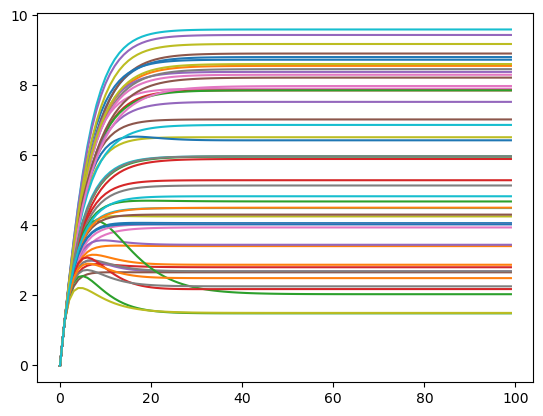

In [5]:
plt.figure()
for n in range(n_model_gens):
    plt.plot(X['R'].sel(model=n, point=0, pop=0))

In [ ]:
# Plot histogram of dr_abs
plt.hist(
    dr_abs, bins=50, color='blue', alpha=0.7,
    #range=(0, 0.03)
)
plt.title('Histogram of |DR|')
plt.xlabel('|DR|')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [55]:
fpath_data = Path().resolve().parent / "data/rates_npops_2_nmodels_512_npts_32_seed_112_ws_0.5_hs_1_dt_0.25_nt_100.nc"
X = xr.open_dataset(fpath_data)

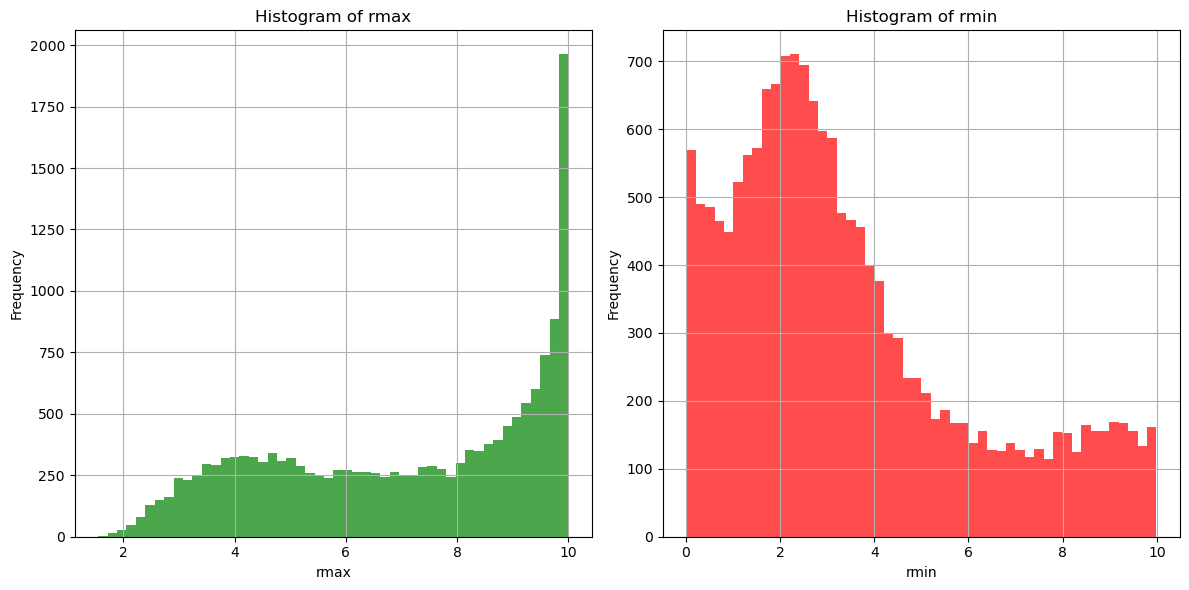

In [59]:
rmax = X['R'].max(dim='pop').values.ravel()
rmin = X['R'].min(dim='pop').values.ravel()

plt.figure(figsize=(12, 6))

# Plot histogram for rmax
plt.subplot(1, 2, 1)
plt.hist(rmax, bins=50, color='green', alpha=0.7)
plt.title('Histogram of rmax')
plt.xlabel('rmax')
plt.ylabel('Frequency')
plt.grid(True)

# Plot histogram for rmin
plt.subplot(1, 2, 2)
plt.hist(rmin, bins=50, color='red', alpha=0.7)
plt.title('Histogram of rmin')
plt.xlabel('rmin')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()